# Libraries

In [22]:
import os
import math
import numpy as np
from scipy import signal
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cupy as cp

#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

axisFontSize = 14
titleFontSize = 20


# Parameters

## Data Path

In [15]:
tracePath = '/content'
traceNum = 10

## Spectrogram

In [9]:
samplingFrequency = int(20e9)  # unit: Hz (set this from the setting of oscilloscope)
windowLength      = 500      # The number of samples in the window.
noverlap          = 450       # Number of points to overlap between segments. If None, noverlap = nperseg // 8. Defaults to None.

## FIR (Finite Impulse Response) filter

In [10]:
filterOrder  = int(1e3 - 1)            # Length of the filter (number of coefficients, i.e. the filter order + 1). numtaps must be odd if a passband includes the Nyquist frequency
filterWidth  = None                    # If width is not None, then assume it is the approximate width of the transition region (expressed in the same units as fs) for use in Kaiser FIR filter design. In this case, the window argument is ignored.
bandPassFreq = [int(50e6), int(150e6)]#, int(895e6), int(905e6), int(995e6), int(1005e6)]#[int(15e6), int(25e6)]  # Cutoff frequency of filter (expressed in the same units as fs) OR an array of cutoff frequencies (that is, band edges). In the latter case, the frequencies in cutoff should be positive and monotonically increasing between 0 and fs/2. The values 0 and fs/2 must not be included in cutoff.

## Alignment

In [11]:
referenceTraceIndex = 3
referenceTraceXrange = [230000, 240000]# [9500, 44500] #[39000, 44900] #[42900, 44900]
correlationCriterion = 0.22           # drop the trace whose maximum of the correlation between the trace and reference trace is under that
traceCutRange = [10000, 35000]

MAwindowSize = 500
jump         = 1
bound        = 5000

## Result

In [12]:
resultFolderName = '{}/alignment_and_drop'.format(tracePath)
os.makedirs(resultFolderName, exist_ok=True)
print(resultFolderName)

with open('{}/parameters.txt'.format(resultFolderName), 'w') as fp:
    fp.write('tracePath: {}\n'.format(tracePath))
    fp.write('filterOrder: {}\n'.format(filterOrder))
    fp.write('filterWidth: {}\n'.format(filterWidth))
    fp.write('bandPassFreq: {}\n'.format(bandPassFreq))
    fp.write('referenceTraceIndex: {}\n'.format(referenceTraceIndex))
    fp.write('referenceTraceXrange: {}\n'.format(referenceTraceXrange))
    fp.write('correlationCriterion: {}\n'.format(correlationCriterion))
    fp.write('traceCutRange: {}\n'.format(traceCutRange))
    fp.write('MAwindowSize: {}\n'.format(MAwindowSize))
    fp.write('jump: {}\n'.format(jump))
    fp.write('bound: {}\n'.format(bound))

/alignment_and_drop


In [13]:
# Check GPU memory capacity
def check_gpu_memory():
    mem_info = cp.cuda.runtime.memGetInfo()
    free_mem = mem_info[0] / (1024 ** 2)  # Free memory in MB
    total_mem = mem_info[1] / (1024 ** 2)  # Total memory in MB
    print(f"GPU Memory - Free: {free_mem:.2f} MB, Total: {total_mem:.2f} MB")
    return free_mem, total_mem

# Determine appropriate chunk size based on available GPU memory
def calculate_chunk_size(free_mem_mb, trace_length, float32_size=4):
    usable_mem_mb = free_mem_mb * 0.8  # Reserve 20% of memory for overhead
    chunk_size = int((usable_mem_mb * (1024 ** 2)) / (trace_length * float32_size))
    print(f"Determined chunk size: {chunk_size} traces")
    return chunk_size

# Optimized GPU-based correlation calculation for multiple traces
def getCorrs_gpu_batch(gpu_traces, gpu_refTrace, gpu_refTraceSum, gpu_refTraceSquSum, traceLen, bound):
    num_traces, trace_length = gpu_traces.shape
    maxCorrs = cp.zeros(num_traces)
    maxCorrIndices = cp.zeros(num_traces, dtype=cp.int32)

    gpu_refTrace = gpu_refTrace.reshape(1, -1)  # Broadcastable shape

    for pointIndex in range(bound, trace_length - traceLen - bound):
        gpu_segments = gpu_traces[:, pointIndex:pointIndex + traceLen]
        traceSums = cp.sum(gpu_segments, axis=1)
        traceSquSums = cp.sum(cp.square(gpu_segments), axis=1)
        corrs = ((traceLen * cp.sum(gpu_segments * gpu_refTrace, axis=1) - traceSums * gpu_refTraceSum) /
                 (cp.sqrt(traceLen * traceSquSums - traceSums ** 2) *
                  cp.sqrt(traceLen * gpu_refTraceSquSum - gpu_refTraceSum ** 2)))

        update_mask = corrs > maxCorrs
        maxCorrs = cp.where(update_mask, corrs, maxCorrs)
        maxCorrIndices = cp.where(update_mask, pointIndex, maxCorrIndices)

    return cp.asnumpy(maxCorrs), cp.asnumpy(maxCorrIndices)

In [17]:
firCoeff = signal.firwin(numtaps=filterOrder, cutoff=bandPassFreq, width=filterWidth, window='hamming', fs=samplingFrequency, pass_zero=False)

GPU Memory - Free: 14995.06 MB, Total: 15102.06 MB
Determined chunk size: 125787 traces


Processing chunks:   0%|          | 0/1 [00:00<?, ?it/s]

[ 0 trace ] corr: 0.248    maxCorrIndex: 9143


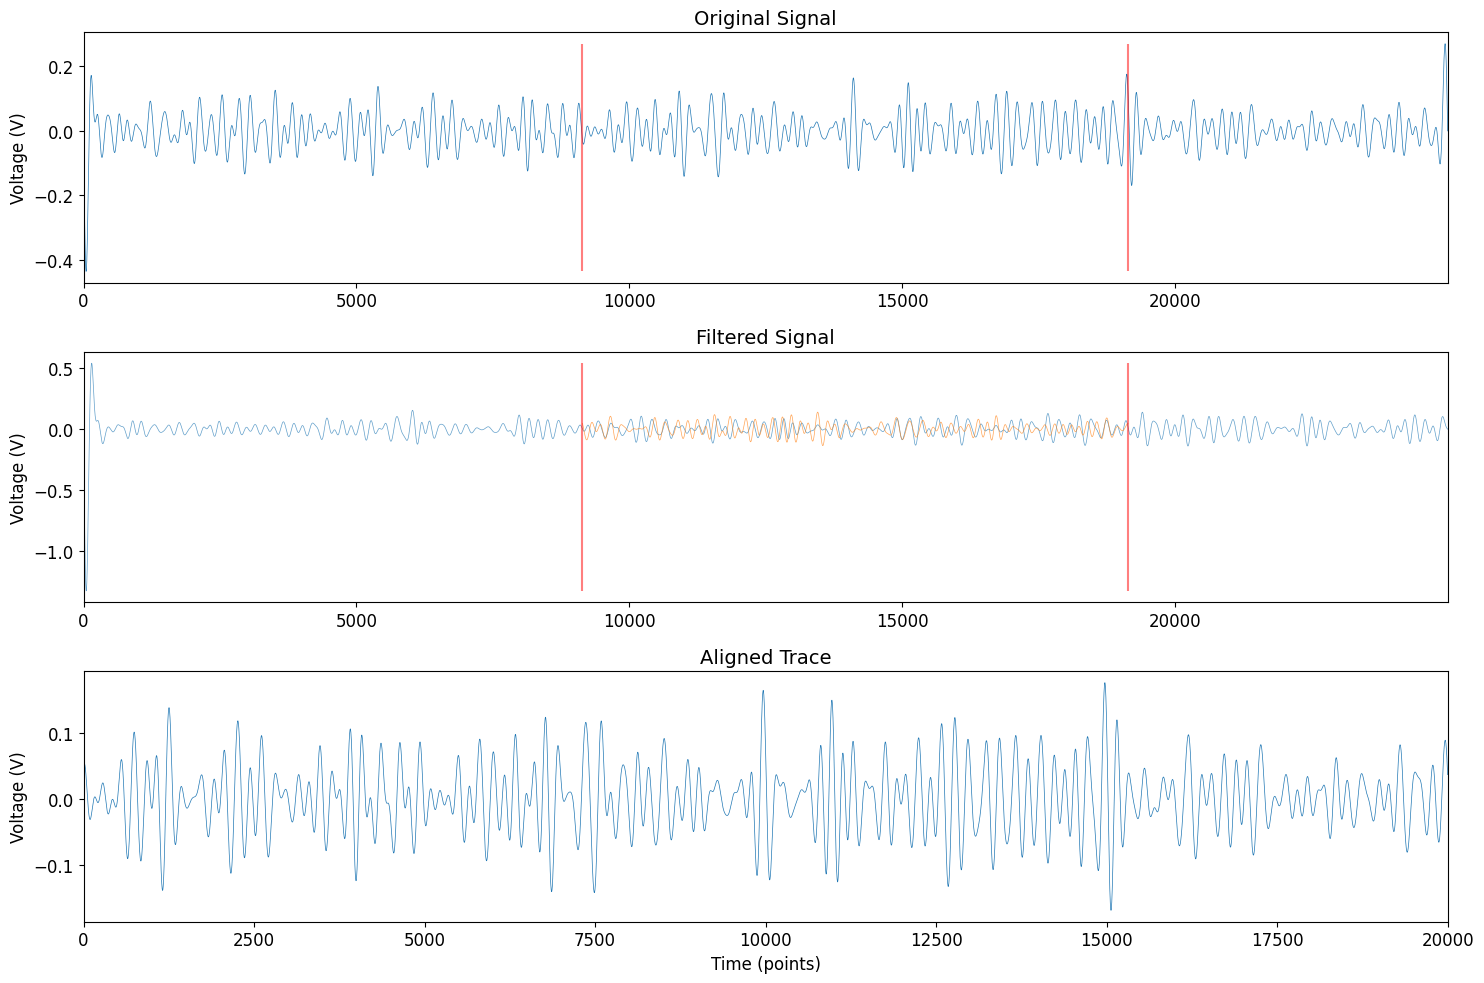

[ 2 trace ] corr: 0.271    maxCorrIndex: 7206


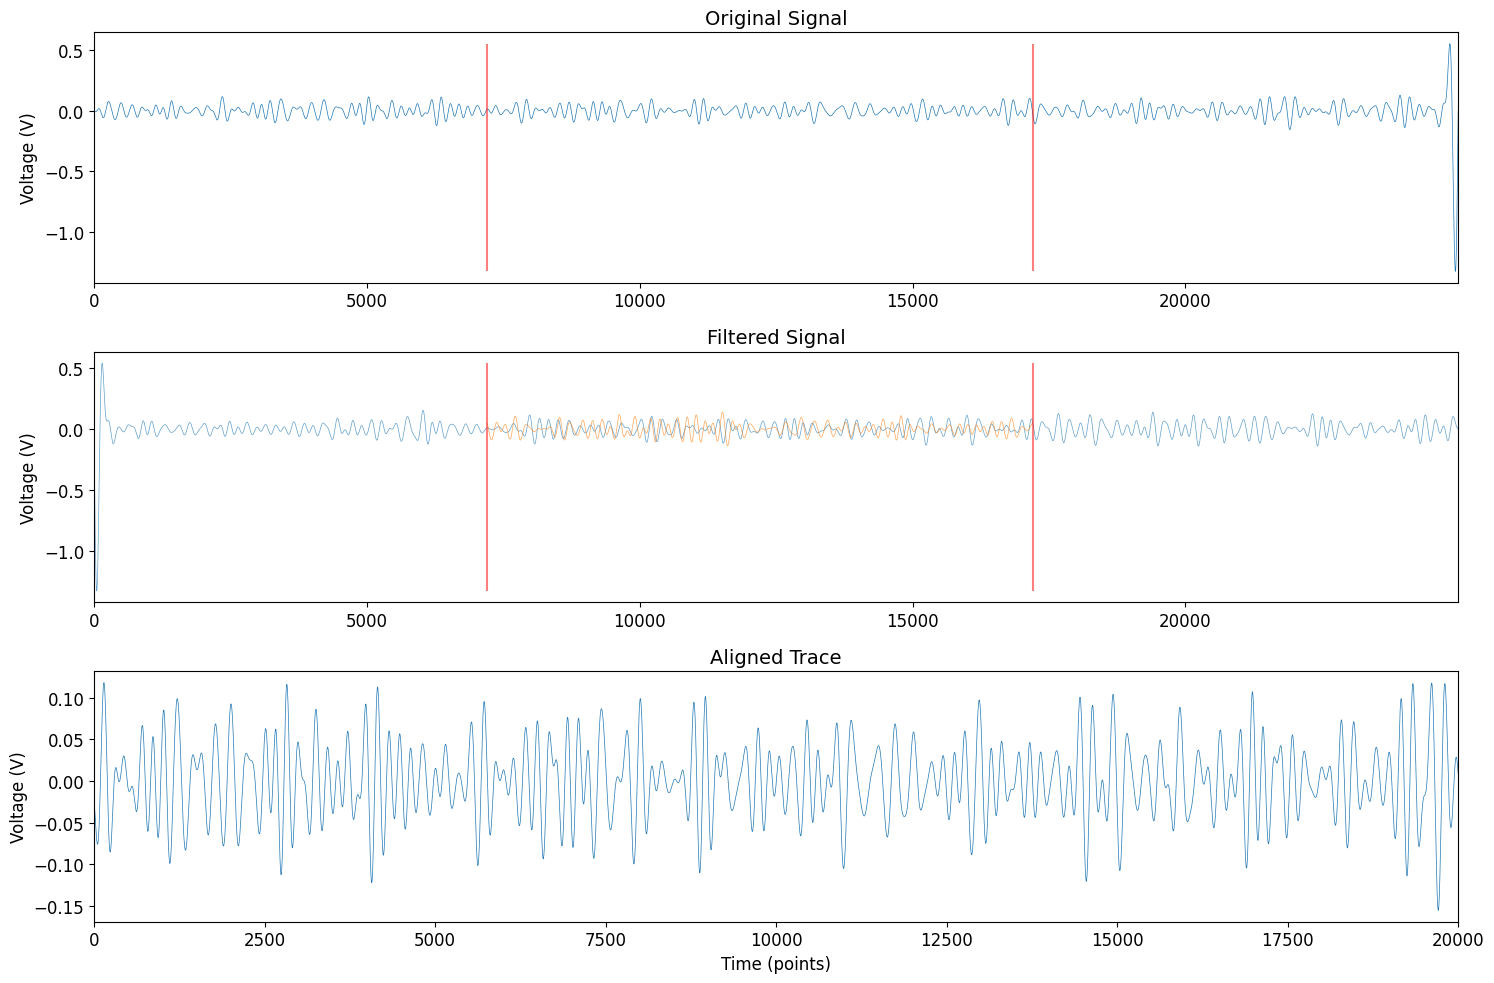

[ 3 trace ] corr: 0.259    maxCorrIndex: 5552


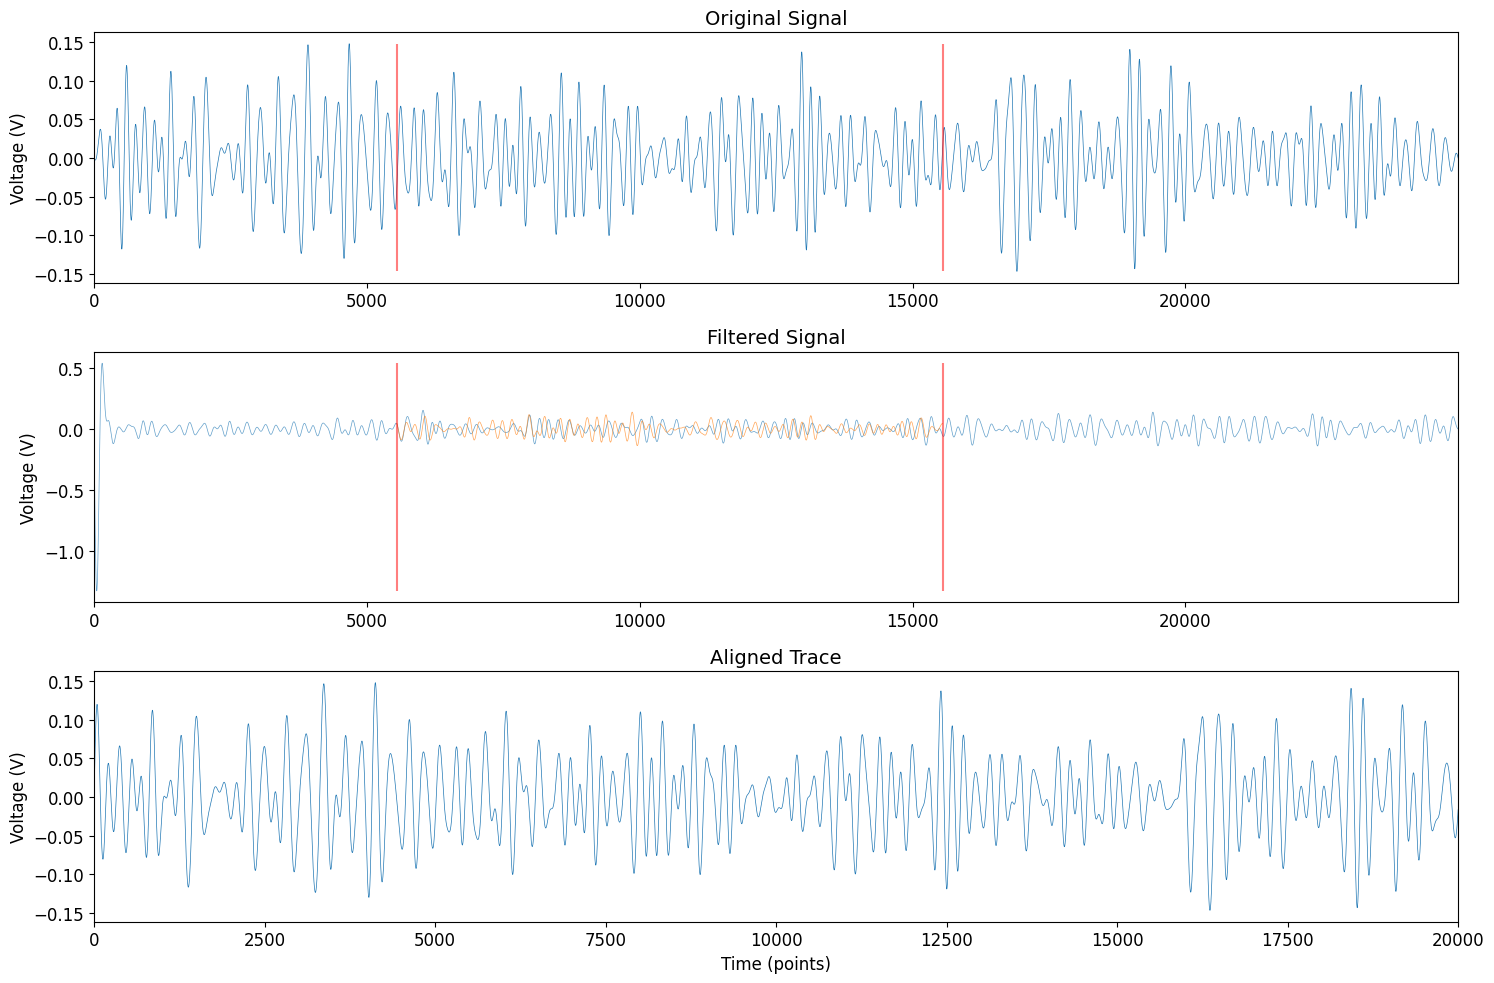

[ 4 trace ] corr: 0.396    maxCorrIndex: 9225


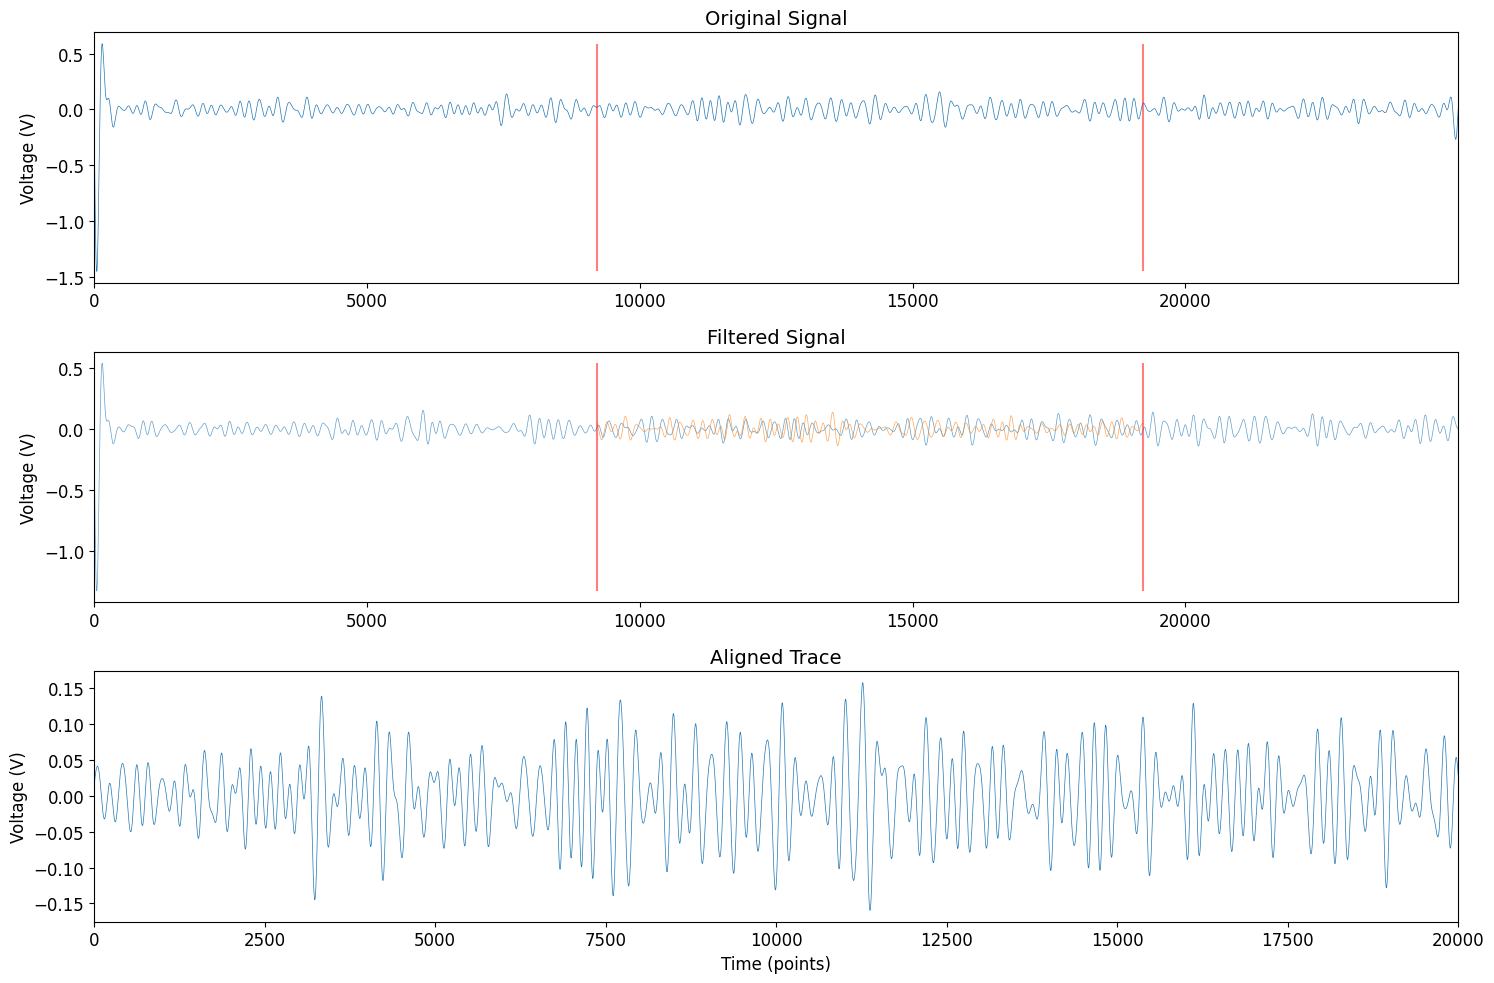

[ 5 trace ] corr: 0.358    maxCorrIndex: 5881


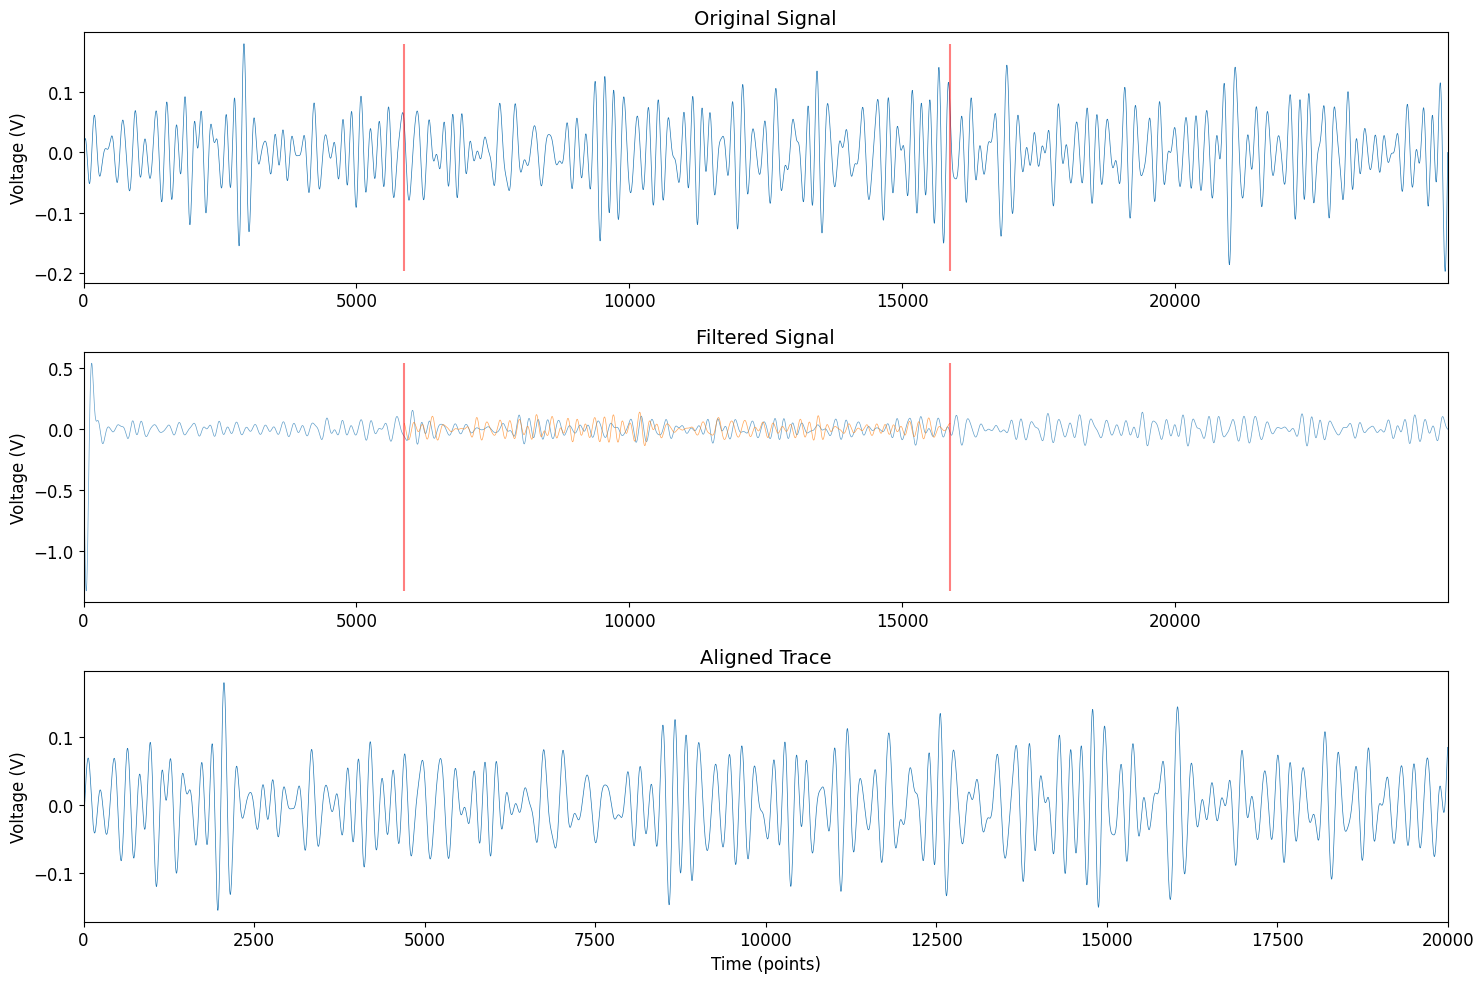

[ 6 trace ] corr: 0.252    maxCorrIndex: 7551


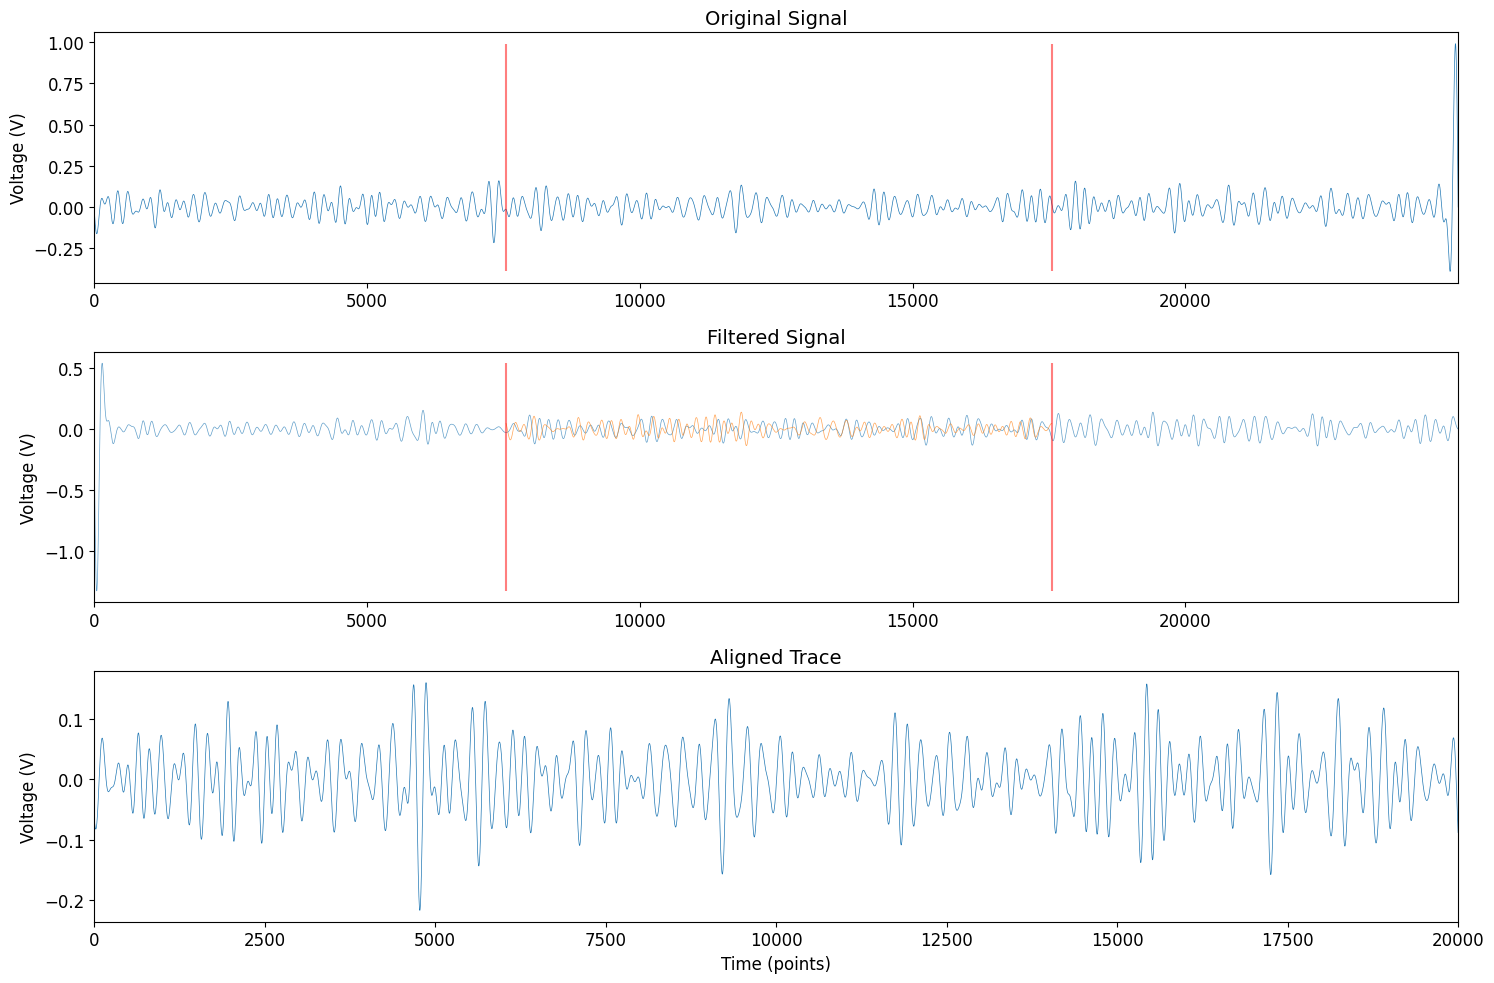

[ 7 trace ] corr: 0.280    maxCorrIndex: 9141


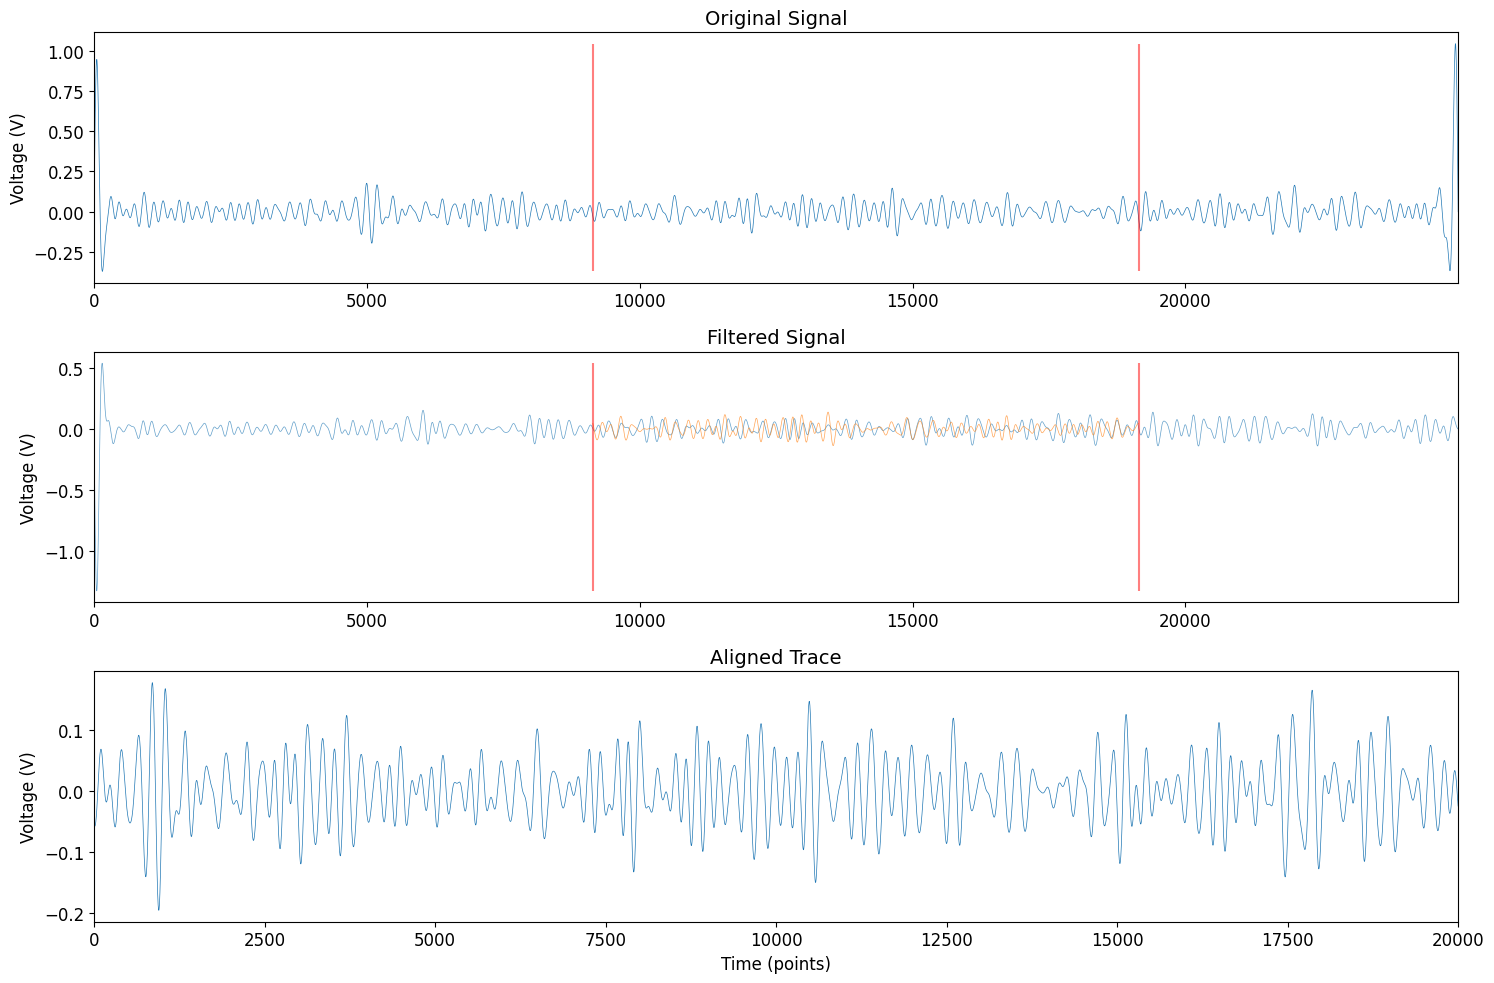

[ 8 trace ] corr: 0.262    maxCorrIndex: 7146


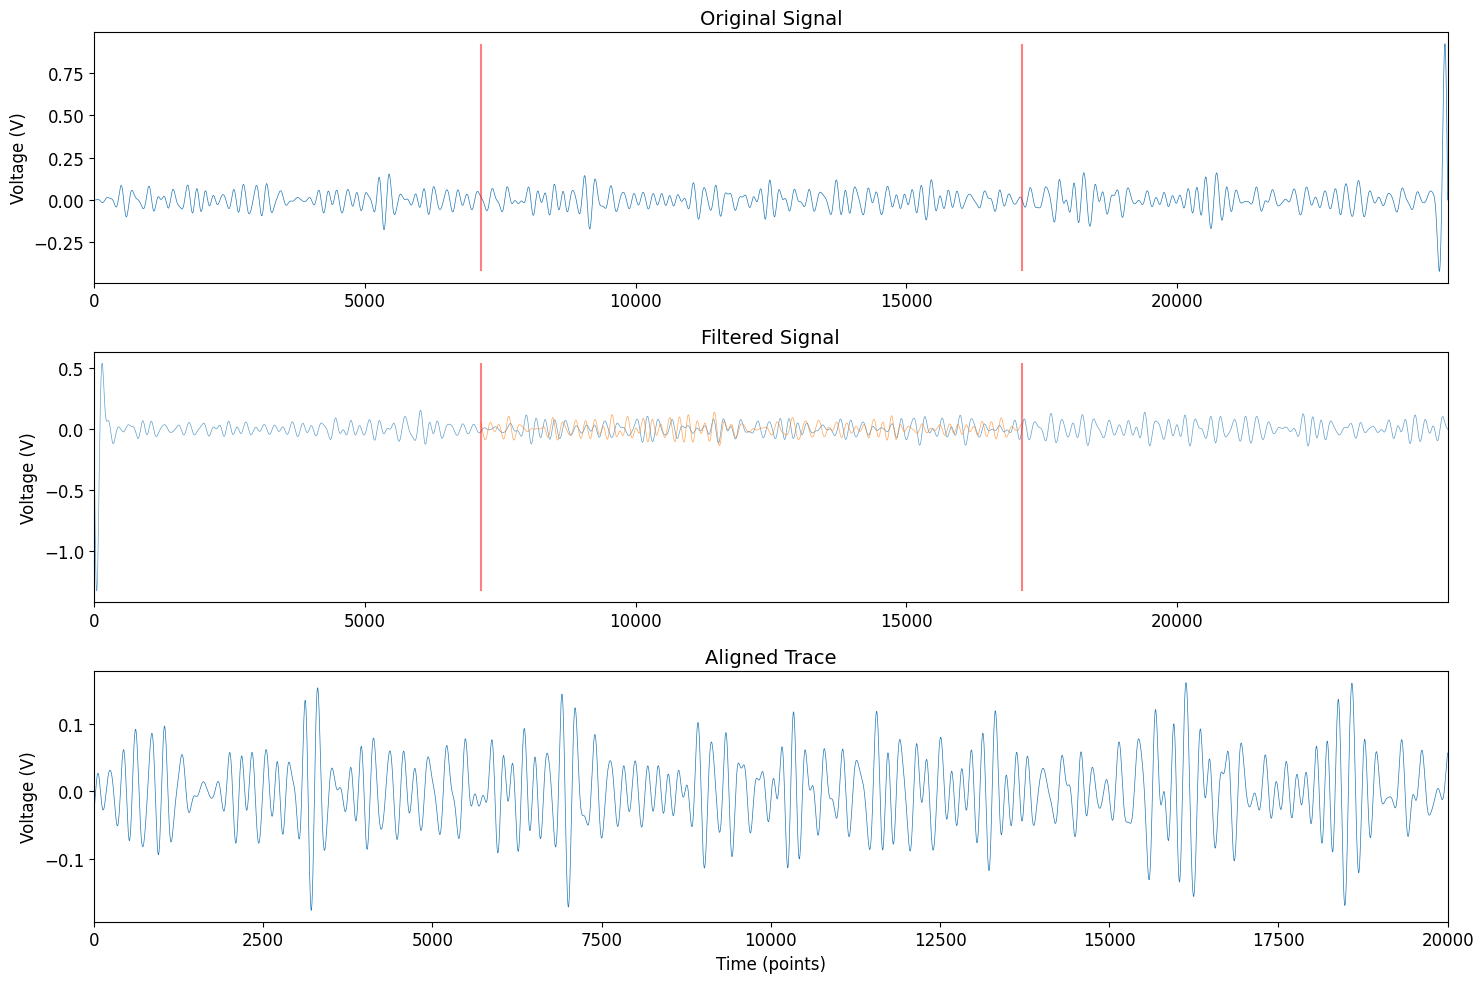

[ 9 trace ] corr: 0.234    maxCorrIndex: 6229


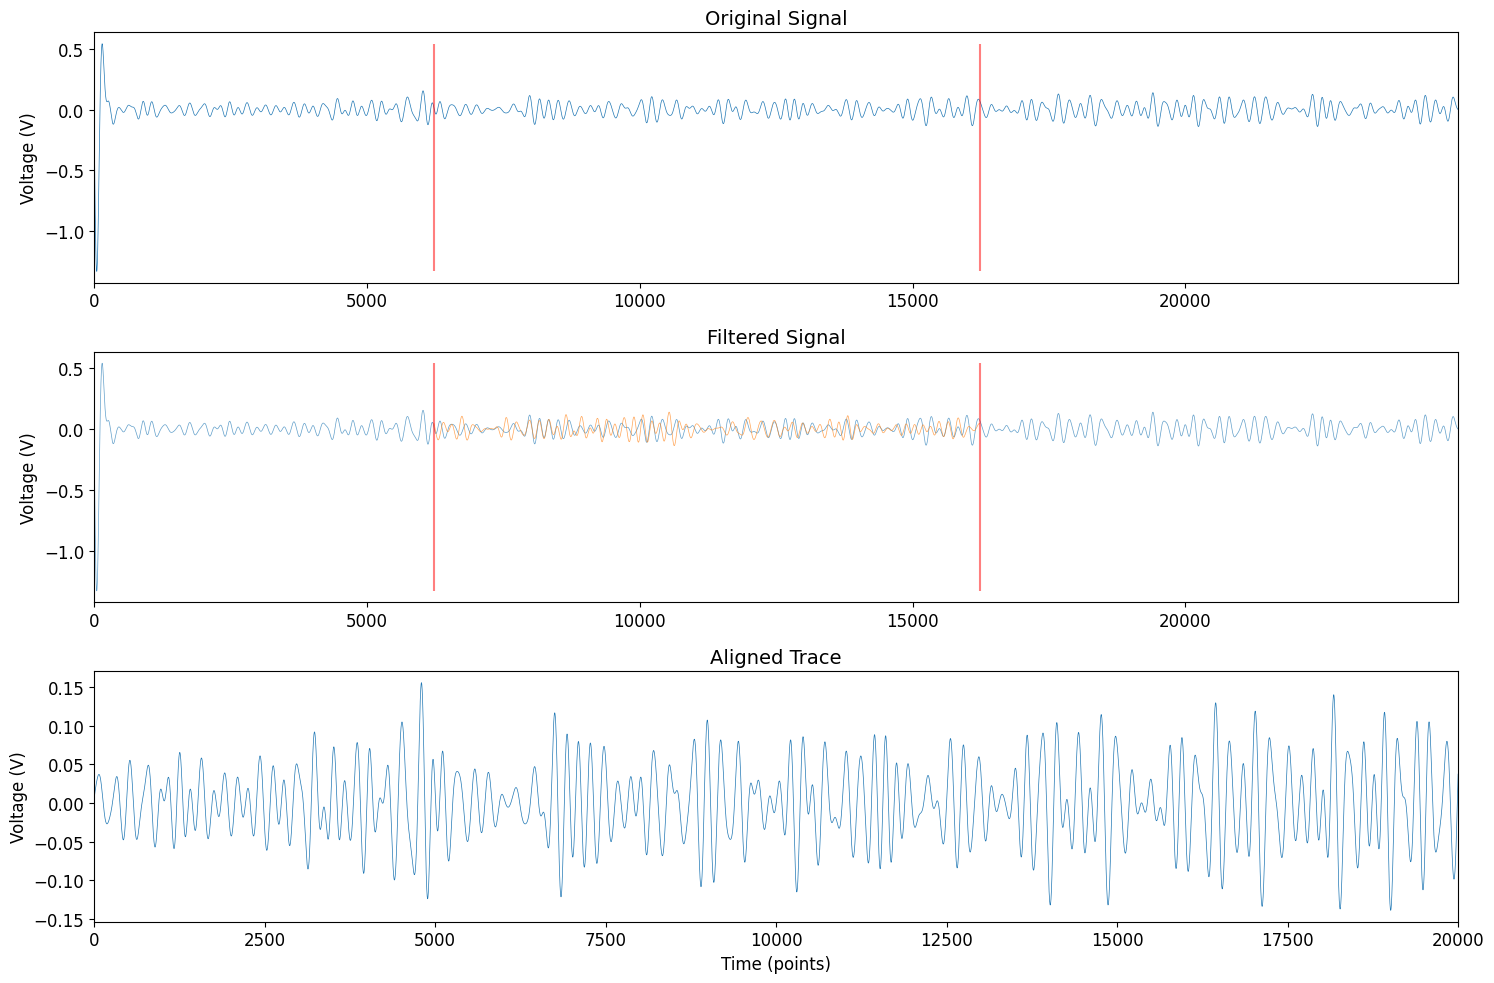

In [23]:
# Load reference trace
refTrace = np.load('{}/trace_{}.npy'.format(tracePath, referenceTraceIndex))
filteredRefTrace = np.array(signal.filtfilt(b=firCoeff, a=1.0, x=refTrace), dtype=np.float32)
filteredRefTrace = filteredRefTrace[referenceTraceXrange[0]:referenceTraceXrange[1]]

refTraceSum = np.sum(filteredRefTrace)
refTraceSquSum = np.sum(np.square(filteredRefTrace))

gpu_refTrace = cp.asarray(filteredRefTrace)
gpu_refTraceSum = cp.asarray(refTraceSum)
gpu_refTraceSquSum = cp.asarray(refTraceSquSum)
alignedIndex = 0

# Check GPU memory before processing
free_mem, total_mem = check_gpu_memory()

# Determine chunk size based on GPU memory
trace_length = traceCutRange[1] - traceCutRange[0]
chunk_size = calculate_chunk_size(free_mem, trace_length)

# Process traces in chunks
gpu_traces = []
chunk_indices = list(range(0, traceNum, chunk_size))
for start_index in tqdm(chunk_indices, desc="Processing chunks"):
    end_index = min(start_index + chunk_size, traceNum)
    cpu_traces = []

    # Load traces for the current chunk
    for traceIndex in range(start_index, end_index):
        trace = np.load('{}/trace_{}.npy'.format(tracePath, traceIndex))[traceCutRange[0]:traceCutRange[1]]
        filteredTrace = np.array(signal.filtfilt(b=firCoeff, a=1.0, x=trace), dtype=np.float32)
        cpu_traces.append(filteredTrace)

    # Upload traces to GPU
    gpu_traces = cp.asarray(cpu_traces)

    # Perform correlation for the current chunk
    maxCorrs, maxCorrIndices = getCorrs_gpu_batch(
        gpu_traces, gpu_refTrace, gpu_refTraceSum, gpu_refTraceSquSum,
        filteredRefTrace.shape[0], bound
    )

    # Save aligned traces
    for traceIndex, (maxCorr, maxCorrIndex) in enumerate(zip(maxCorrs, maxCorrIndices), start=start_index):
        if maxCorr >= correlationCriterion:
            trace = gpu_traces[traceIndex - start_index].get()  # Transfer individual trace back to CPU
            if 0 <= maxCorrIndex - bound and maxCorrIndex + filteredRefTrace.shape[0] + bound < len(trace):
                np.save('{}/alignTrace{}.npy'.format(resultFolderName, alignedIndex),
                        trace[maxCorrIndex - bound: maxCorrIndex + filteredRefTrace.shape[0] + bound])
                alignedIndex += 1

                print(f'[ {traceIndex} trace ] corr: {maxCorr:.3f}    maxCorrIndex: {maxCorrIndex}')
                # Plot the first 1000 traces of the first chunk
                if start_index == 0 and traceIndex < 1000:
                    plt.figure(figsize=(15, 10))
                    plt.subplot(3, 1, 1)
                    plt.title('Original Signal', fontsize=14)
                    plt.plot(trace, linewidth=0.5)
                    plt.xlim(0, len(trace) - 1)
                    plt.ylabel('Voltage (V)', fontsize=12)
                    plt.vlines(maxCorrIndex, np.min(trace), np.max(trace), color='r', alpha=0.5)
                    plt.vlines(maxCorrIndex + len(filteredRefTrace), np.min(trace), np.max(trace), color='r', alpha=0.5)

                    plt.subplot(3, 1, 2)
                    plt.title('Filtered Signal', fontsize=14)
                    plt.plot(filteredTrace, linewidth=0.5, alpha=0.7)
                    plt.plot(np.arange(maxCorrIndex, maxCorrIndex + len(filteredRefTrace)),
                             filteredRefTrace, linewidth=0.5, alpha=0.7)
                    plt.xlim(0, len(filteredTrace) - 1)
                    plt.ylabel('Voltage (V)', fontsize=12)
                    plt.vlines(maxCorrIndex, np.min(filteredTrace), np.max(filteredTrace), color='r', alpha=0.5)
                    plt.vlines(maxCorrIndex + len(filteredRefTrace), np.min(filteredTrace), np.max(filteredTrace), color='r', alpha=0.5)

                    plt.subplot(3, 1, 3)
                    plt.title('Aligned Trace', fontsize=14)
                    plt.plot(trace[maxCorrIndex - bound:maxCorrIndex + len(filteredRefTrace) + bound], linewidth=0.5)
                    plt.xlim(0, len(filteredRefTrace) + 2 * bound)
                    plt.ylabel('Voltage (V)', fontsize=12)
                    plt.xlabel('Time (points)', fontsize=12)
                    plt.tight_layout()
                    plt.show()
